In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class StandardScaler:
    """Custom implementation of StandardScaler"""
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X):
        """Compute the mean and standard deviation of X for later scaling"""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=1)  
        self.scale_[self.scale_ == 0] = 1
        return self
        
    def transform(self, X):
        """Scale the data"""
        return (X - self.mean_) / self.scale_
        
    def fit_transform(self, X):
        """Fit to data, then transform it"""
        return self.fit(X).transform(X)
        
    def inverse_transform(self, X):
        """Scale back to original representation"""
        return X * self.scale_ + self.mean_

def train_test_split(X, y, test_size=0.2, random_state=None):
    """Custom implementation of train_test_split"""
    if random_state is not None:
        np.random.seed(random_state)
        
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [3]:
class LassoRegression:
    def __init__(self, alpha=1.0, max_iter=3000, tol=1e-6, learning_rate=0.001,
                 batch_size=32, decay_rate=0.95, early_stopping_rounds=50):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.val_loss_history = []
        self.weights_path = []
        self.best_weights = None
        self.best_bias = None
        self.best_val_loss = float('inf')
        
    def soft_thresholding(self, x, lambda_):
        return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)
    
    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_features = X.shape
        
        if X_val is None or y_val is None:
            val_size = int(0.1 * n_samples)
            indices = np.random.permutation(n_samples)
            X_val = X[indices[:val_size]]
            y_val = y[indices[:val_size]]
            X = X[indices[val_size:]]
            y = y[indices[val_size:]]
            n_samples = len(X)

        if self.weights is None:
            self.weights = np.random.randn(n_features) * 0.01
        if self.bias is None:
            self.bias = 0.0
            
        X_mean = np.mean(X, axis=0)
        X_std = np.std(X, axis=0)
        X_normalized = (X - X_mean) / (X_std + 1e-10)
        X_val_normalized = (X_val - X_mean) / (X_std + 1e-10)
        
        self.loss_history = []
        self.val_loss_history = []
        self.weights_path = []
        
        current_lr = self.learning_rate
        no_improvement = 0
        
        for iteration in range(self.max_iter):
            self.weights_path.append(self.weights.copy())
            
            indices = np.random.permutation(n_samples)
            for start_idx in range(0, n_samples, self.batch_size):
                batch_idx = indices[start_idx:start_idx + self.batch_size]
                X_batch = X_normalized[batch_idx]
                y_batch = y[batch_idx]
                
                y_pred_batch = np.dot(X_batch, self.weights) + self.bias
                
                dw = ((-2/len(batch_idx)) * np.dot(X_batch.T, (y_batch - y_pred_batch)) + 
                     0.001 * self.weights)  
                db = (-2/len(batch_idx)) * np.sum(y_batch - y_pred_batch)
                
                self.weights = self.soft_thresholding(
                    self.weights - current_lr * dw,
                    self.alpha * current_lr
                )
                self.bias -= current_lr * db
            
            current_loss = self._compute_loss(X_normalized, y)
            self.loss_history.append(current_loss)
            
            val_loss = self._compute_loss(X_val_normalized, y_val)
            self.val_loss_history.append(val_loss)
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_weights = self.weights.copy()
                self.best_bias = self.bias
                no_improvement = 0
            else:
                no_improvement += 1
                
            if no_improvement >= 10:
                current_lr *= self.decay_rate
                no_improvement = 0
                
            if no_improvement >= self.early_stopping_rounds:
                print(f"Early stopping at iteration {iteration}")
                break
                
            if iteration > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.tol:
                break
        
        self.weights = self.best_weights
        self.bias = self.best_bias
            
        self.weights = self.weights / (X_std + 1e-10)
        self.bias = self.bias - np.sum(self.weights * X_mean)
        
        return self
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def _compute_loss(self, X, y):
        y_pred = np.dot(X, self.weights) + self.bias
        mse = np.mean((y - y_pred) ** 2)
        l1_penalty = self.alpha * np.sum(np.abs(self.weights))
        return mse + l1_penalty

In [5]:
def generate_dataset(n_samples=1000, n_features=20, noise_level=0.1):
    np.random.seed(42)
    
    X = np.random.uniform(-2, 2, (n_samples, n_features))
    
    X_poly = np.column_stack([
        X,
        np.square(X[:, :2]),  
        np.exp(X[:, 2:4] / 2),  
        np.sin(X[:, 4:6])  
    ])
    
    X_poly[:, 0] = 0.7 * X_poly[:, 1] + 0.3 * np.random.randn(n_samples)
    X_poly[:, 2] = -0.5 * X_poly[:, 3] + 0.5 * np.random.randn(n_samples)
    
    outlier_idx = np.random.choice(n_samples, size=int(0.05 * n_samples), replace=False)
    X[outlier_idx] *= np.random.uniform(5, 10, size=(len(outlier_idx), 1))
    
    n_nonzero = int(0.3 * n_features)
    true_weights = np.zeros(n_features)
    nonzero_idx = np.random.choice(n_features, n_nonzero, replace=False)
    true_weights[nonzero_idx] = np.random.uniform(-2, 2, size=n_nonzero)
    
    true_weights[nonzero_idx[:2]] *= 10  
    true_weights[nonzero_idx[2:4]] *= 0.01  
    
    y_linear = np.dot(X, true_weights)
    
    y_nonlinear = (
        0.5 * np.sin(X[:, 0]) +  
        0.3 * np.exp(X[:, 1] / 5) +  
        0.2 * np.square(X[:, 2]) +  
        0.1 * np.cbrt(X[:, 3]) +  
        0.4 * np.tanh(X[:, 4])  
    )
    
    y_interaction = (
        0.2 * X[:, 0] * X[:, 1] +  
        0.1 * X[:, 2] * X[:, 3] * X[:, 4] +  
        0.05 * np.sin(X[:, 0]) * np.cos(X[:, 1])  
    )
    
    base_noise = np.random.randn(n_samples)
    heteroscedastic_noise = noise_level * (1 + np.abs(X[:, 0])) * base_noise
    
    breakpoints = np.random.choice(n_samples, 3, replace=False)
    y_breaks = np.zeros(n_samples)
    y_breaks[breakpoints] = np.random.uniform(2, 5, size=3)
    
    y = (y_linear + 
         y_nonlinear + 
         y_interaction + 
         heteroscedastic_noise + 
         y_breaks)
    
    seasonal_pattern = 0.5 * np.sin(np.linspace(0, 4*np.pi, n_samples))
    y += seasonal_pattern
    
    return X, y, true_weights

def plot_training_progress(model, feature_names=None):
    """Plot training progress including loss history and weight paths"""
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(model.loss_history)
    plt.title('Loss History during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    weights_path = np.array(model.weights_path)
    for i in range(weights_path.shape[1]):
        label = f'Feature {i}' if feature_names is None else feature_names[i]
        plt.plot(weights_path[:, i], label=label, alpha=0.7)
    plt.title('Weight Paths during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Weight Value')
    if weights_path.shape[1] <= 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_true_vs_predicted(y_true, y_pred, y_scaler=None):
    """Plot true vs predicted values with regression line, showing both scaled and original values"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.scatter(y_true, y_pred, alpha=0.5)
    ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax1.set_title('Scaled True vs Predicted Values')
    ax1.set_xlabel('True Values (scaled)')
    ax1.set_ylabel('Predicted Values (scaled)')
    
    if y_scaler is not None:
        y_true_orig = y_scaler.inverse_transform(y_true.reshape(-1, 1)).ravel()
        y_pred_orig = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        ax2.scatter(y_true_orig, y_pred_orig, alpha=0.5)
        ax2.plot([y_true_orig.min(), y_true_orig.max()], 
                [y_true_orig.min(), y_true_orig.max()], 'r--', lw=2)
        ax2.set_title('Original Scale True vs Predicted Values')
        ax2.set_xlabel('True Values (original)')
        ax2.set_ylabel('Predicted Values (original)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Scaled data range - True: [{y_true.min():.2f}, {y_true.max():.2f}], "
          f"Predicted: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    if y_scaler is not None:
        print(f"Original data range - True: [{y_true_orig.min():.2f}, {y_true_orig.max():.2f}], "
              f"Predicted: [{y_pred_orig.min():.2f}, {y_pred_orig.max():.2f}]")

def plot_weight_comparison(true_weights, estimated_weights):
    """Plot comparison between true and estimated weights"""
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(true_weights))
    width = 0.35
    
    plt.bar(x - width/2, true_weights, width, label='True Weights', alpha=0.7)
    plt.bar(x + width/2, estimated_weights, width, label='Estimated Weights', alpha=0.7)
    
    plt.title('True vs Estimated Weights Comparison')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

Train MSE: 0.1745
Test MSE: 0.3627


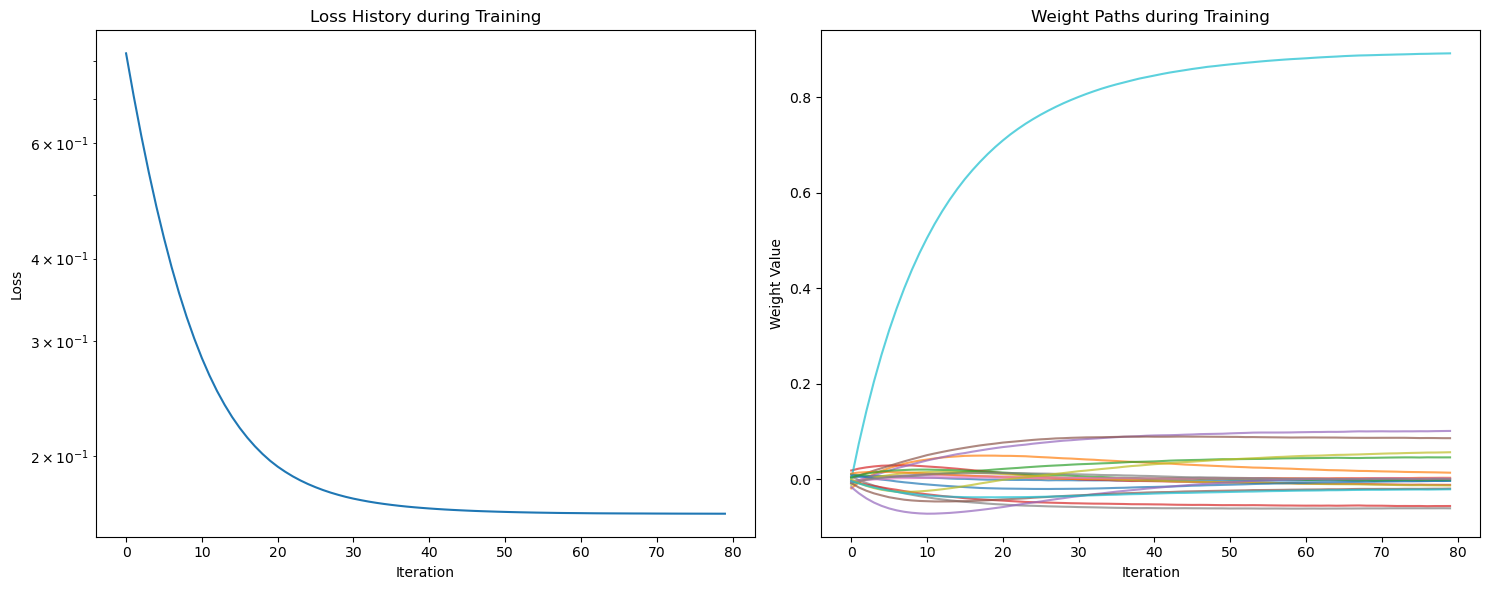

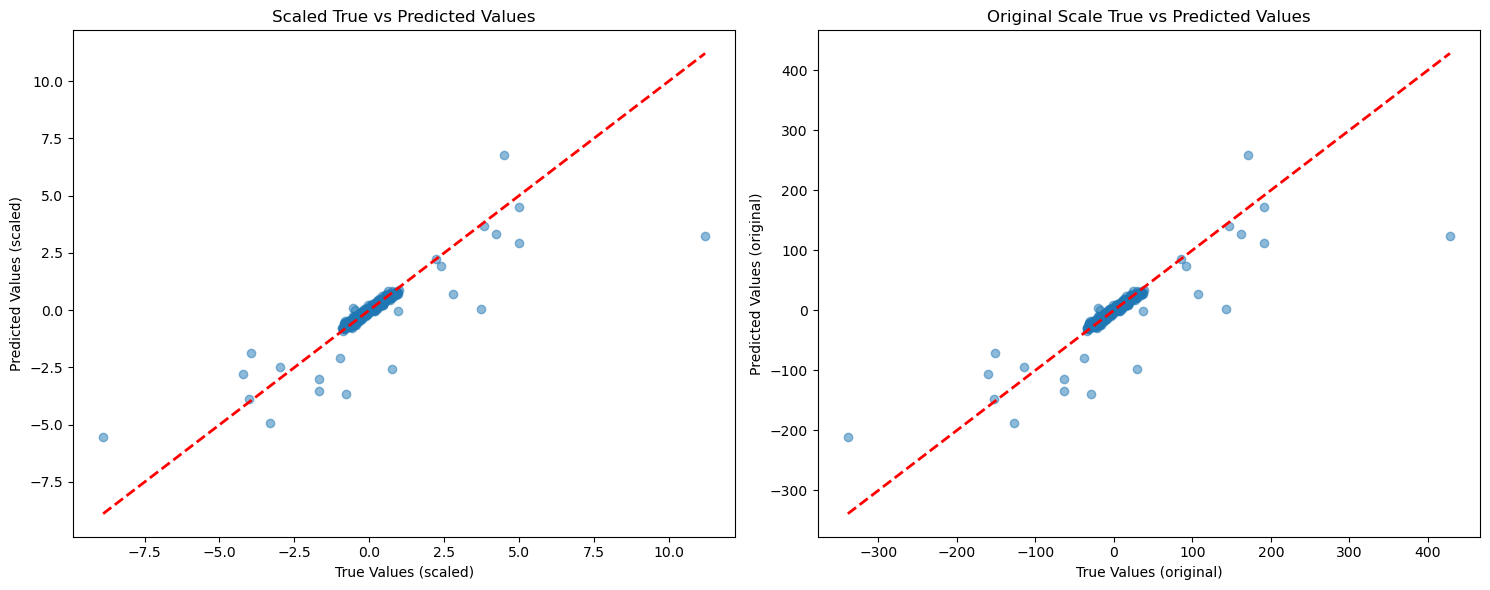

Scaled data range - True: [-8.88, 11.21], Predicted: [-5.53, 6.76]
Original data range - True: [-338.73, 428.07], Predicted: [-210.62, 258.16]


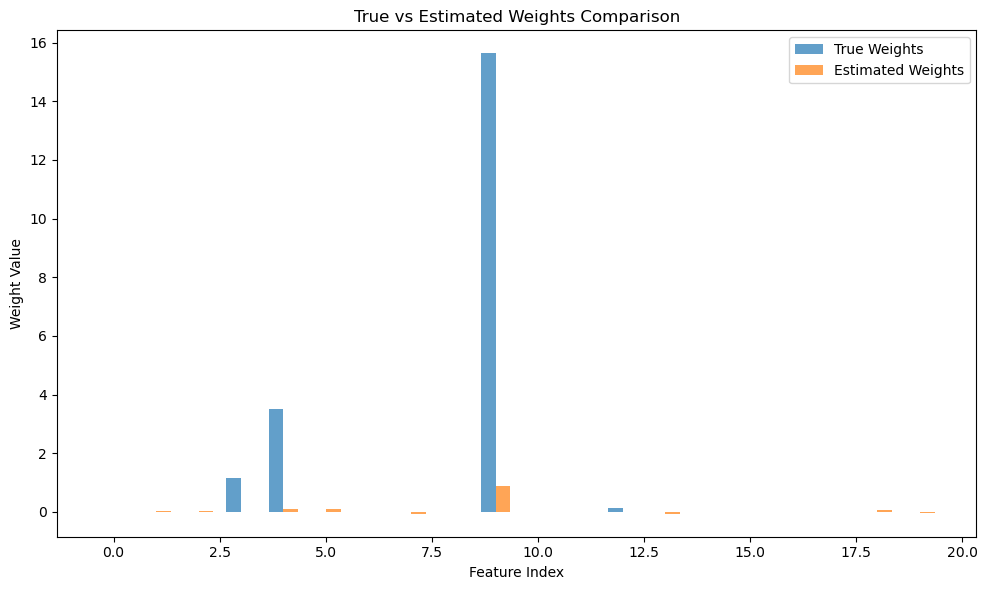

In [7]:
if __name__ == "__main__":
    X, y, true_weights = generate_dataset(
    n_samples=2000,
    n_features=20,
    noise_level=0.05
    )
    
    y_scaler = StandardScaler()
    y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LassoRegression(
        alpha=0.01,
        max_iter=3000,
        learning_rate=0.001,
        batch_size=32,
        decay_rate=0.95,
        early_stopping_rounds=50
    )
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)
    
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    
    plot_training_progress(model)
    plot_true_vs_predicted(y_test, y_pred, y_scaler)
    plot_weight_comparison(true_weights, model.weights)